<center> 

# Taller 1: Fundamentos de Analítica II
Luisa F. Giraldo - 
Juan S. Guzman
</center>

### Enunciado del ejercicio: 
Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses. Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.



In [2]:
# Importamos los paquetes a usar

import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos 
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error

In [4]:
#Procedemos a la carga de los datos

data = pd.read_excel("datosEmpleo.xlsx",index_col='mes',parse_dates=True) #La fecha del registro queda como índica
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


## 1. Análisis de la serie: 

Graficamos la serie para comprender graficamente su dinámica: 

(220, 4)


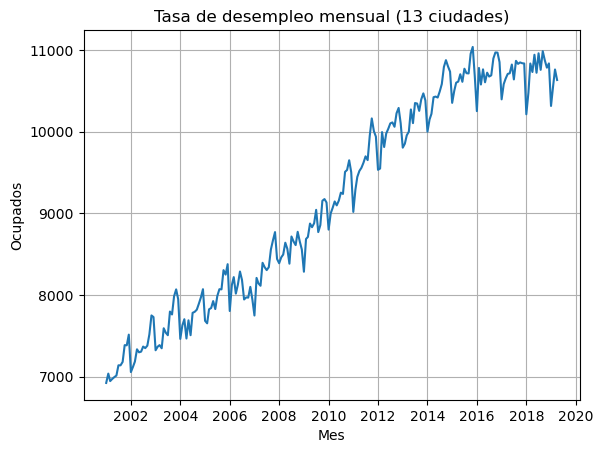

In [5]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
plt.title("Tasa de ocupación mensual (13 ciudades)")
plt.xlabel("Mes")
plt.ylabel("Ocupados")
plt.plot(data[["Ocupados"]])
plt.grid()
plt.show()

Vemos que la serie tiene una tendencia creciente y parece contener cierta estacionalidad. Procedemos a descomponerla en sus distintas partes: 

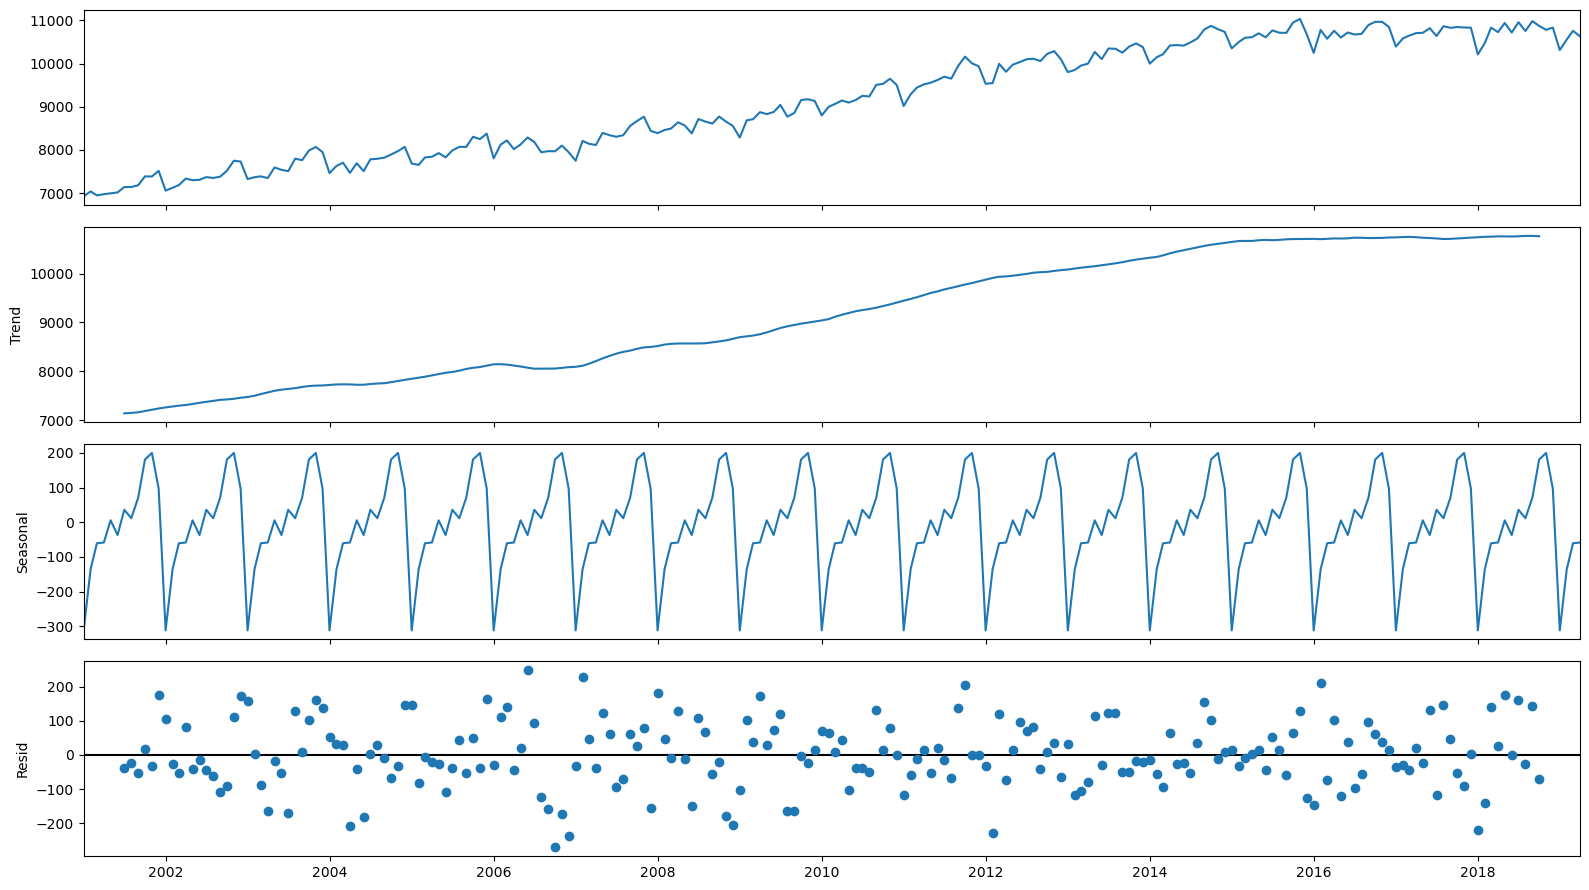

In [6]:
#Descomposición de la serie de tiempo

td_componentes = seasonal_decompose(data[["Ocupados"]],model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

Como lo decíamos arriba, la serie presenta una tendencia creciente en el tiempo con una estacionalidad que evidencia que la ocupación crece paulatinamente en el año y se desploma al final de este; y este comportamiento se mantiene año a año. 

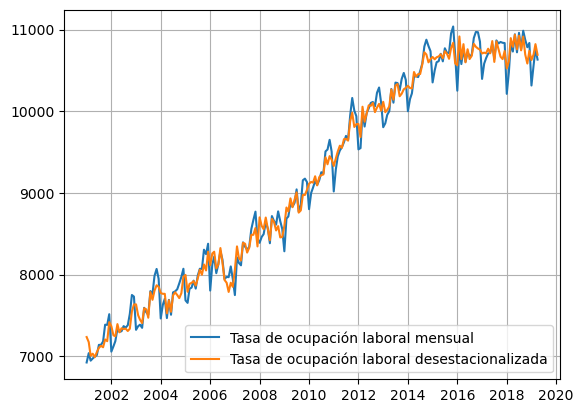

In [8]:
td_desestacionalizada = data["Ocupados"]-td_componentes.seasonal

plt.plot(data[["Ocupados"]],label="Tasa de ocupación laboral mensual")
plt.plot(td_desestacionalizada,label="Tasa de ocupación laboral desestacionalizada")
plt.legend()
plt.grid()
plt.show()


Al desestacionalizar la serie (gráfica naranja) vemos especialmente que las caídas en la ocupación al final del año se suavizan un poco. 

## 2. Métodos de suavización

Iniciamos partiendo el data set en datos de entrenamiento y datos de prueba para afinar el modelo antes de proceder a la predicción.

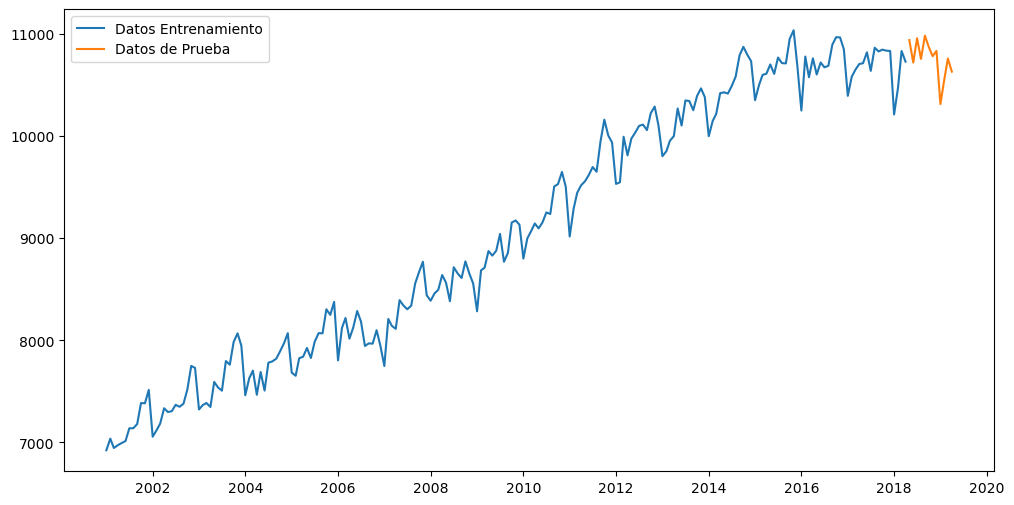

In [9]:
train_len = 208
train_td = data[["Ocupados"]][:train_len]
test_td = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(test_td,label="Datos de Prueba")
plt.legend()
plt.show()